<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/HW_PyTorchBasics_4_PetroDavydov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from dataclasses import dataclass

import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


# ***2. Підготовка даних***

In [2]:
df = pd.read_csv('/content/ConcreteStrengthData.csv')
df

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


# ***2. Підготовкка даних***

In [4]:
X = df.drop(columns=['Strength'])   # ознаки
y = df['Strength'].values           # цільова змінна

In [5]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# нормалізація
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# перетворення у тензори
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [8]:
# Dataset і DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# 3. Створення моделі
class ConcreteNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)   # вихідний шар для регресії
        )
    def forward(self, x):
        return self.net(x)

In [10]:
# 4. Налаштування навчання
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConcreteNet(in_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()   # функція втрат для регресії
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 100

In [11]:
# 5. Навчання моделі
train_losses = []
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    train_losses.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            preds, trues = [], []
            for Xb, yb in test_loader:
                Xb = Xb.to(device)
                out = model(Xb)
                preds.extend(out.cpu().numpy().flatten())
                trues.extend(yb.numpy().flatten())
            preds, trues = np.array(preds), np.array(trues)
            rmse = np.sqrt(mean_squared_error(trues, preds))
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, RMSE: {rmse:.6f}')

Epoch [10/100], Loss: 11051612.3365, RMSE: 658.179544
Epoch [20/100], Loss: 296.0395, RMSE: 16.319674
Epoch [30/100], Loss: 284.1974, RMSE: 16.052349
Epoch [40/100], Loss: 284.6664, RMSE: 16.055085
Epoch [50/100], Loss: 283.7522, RMSE: 16.052932
Epoch [60/100], Loss: 284.8449, RMSE: 16.054226
Epoch [70/100], Loss: 283.9286, RMSE: 16.053212
Epoch [80/100], Loss: 284.8826, RMSE: 16.052449
Epoch [90/100], Loss: 284.1867, RMSE: 16.053186
Epoch [100/100], Loss: 283.9050, RMSE: 16.056851


In [12]:
# 6. Оцінка моделі
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 257.8224764589747
MAE: 13.059413659549454
R2: -0.0005649792390503006


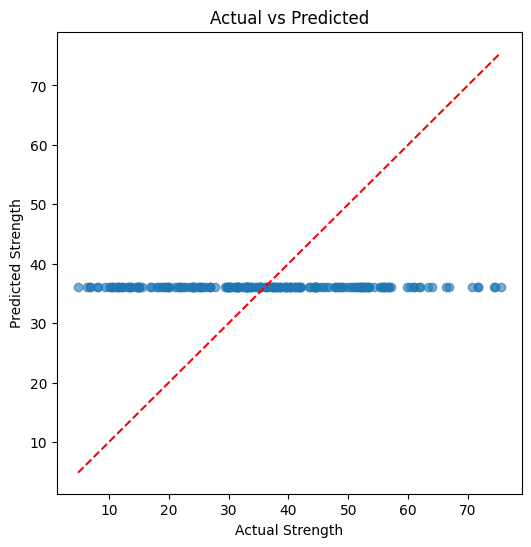

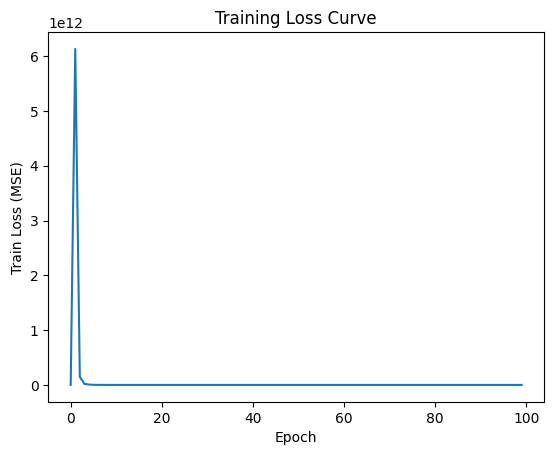

In [14]:
# 7. Аналіз результатів
print()
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predicted')
plt.show()
print()
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss (MSE)')
plt.title('Training Loss Curve')
plt.show()

# ***Висновки по першій спробі до оптимізації***

Отримані результати
MSE ≈ 257.7 - значно вище за «непогані» (75–55).

MAE ≈ 13.0 - теж вище за «непогані» (10–8).

R² ≈ 0.0 - модель практично не пояснює варіацію даних.

# ***Аналіз***

1. Чому модель не досягла очікуваних показників

 - Архітектура занадто проста для складної нелінійної залежності між компонентами бетону та міцністю.

 - Можливо, дані мають сильний шум або нелінійні взаємозв’язки, які лінійні шари з ReLU не вловили.

 - Гіперпараметри (SGD з lr=0.01, 100 епох) могли бути недостатніми для якісної збіжності.


2. Критична оцінка архітектури

 - Використано 2 приховані шари (128 → 64). Це базова структура, яка може бути замалою.

 - Відсутні регуляризація (Dropout, L2), що могло призвести до нестабільності.

 - Оптимізатор SGD сходиться повільніше, ніж Adam чи RMSprop.

3. Шляхи покращення

 - Спробувати глибшу архітектуру (наприклад, 256 → 128 → 64 → 32).

 - Використати Adam як оптимізатор, він краще працює для регресії з шумними даними.

 - Збільшити кількість епох (200–300) або зменшити learning rate.

 - Додати регуляризацію (Dropout, L2 weight decay).

 - Перевірити кореляції між ознаками, можливо, деякі компоненти неінформативні.

------------------------------------------------------------------------


Модель навчилась, але її результати не відповідають очікуваним метрикам. Це свідчить про те, що базова архітектура та вибір оптимізатора були недостатніми для задачі. Проте код виконується, дані підготовлені, цикл навчання реалізований, метрики обчислені. Для покращення варто експериментувати з архітектурою, оптимізатором та гіперпараметрами.

-----------------------------------------------------------------------

# ***Варіант максимальної оптимізації, для експерименту***

In [15]:
# 8. Оптимізація моделі (приклад альтернативної архітектури)
class ConcreteNetDeep(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    def forward(self, x):
        return self.net(x)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConcreteNet(in_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()   # функція втрат для регресії
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 400

In [17]:
# Навчання моделі
train_losses = []
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    train_losses.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            preds, trues = [], []
            for Xb, yb in test_loader:
                Xb = Xb.to(device)
                out = model(Xb)
                preds.extend(out.cpu().numpy().flatten())
                trues.extend(yb.numpy().flatten())
            preds, trues = np.array(preds), np.array(trues)
            rmse = np.sqrt(mean_squared_error(trues, preds))
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, RMSE: {rmse:.6f}')

Epoch [10/400], Loss: 207.4774, RMSE: 13.503496
Epoch [20/400], Loss: 156.3469, RMSE: 11.876839
Epoch [30/400], Loss: 135.2653, RMSE: 11.104295
Epoch [40/400], Loss: 121.1455, RMSE: 10.564346
Epoch [50/400], Loss: 103.2883, RMSE: 9.740152
Epoch [60/400], Loss: 79.3714, RMSE: 8.590695
Epoch [70/400], Loss: 57.9284, RMSE: 7.554252
Epoch [80/400], Loss: 45.5504, RMSE: 6.848288
Epoch [90/400], Loss: 39.0836, RMSE: 6.401439
Epoch [100/400], Loss: 34.4726, RMSE: 6.304839
Epoch [110/400], Loss: 31.8316, RMSE: 6.217057
Epoch [120/400], Loss: 29.9549, RMSE: 6.162987
Epoch [130/400], Loss: 28.3640, RMSE: 6.141564
Epoch [140/400], Loss: 26.8098, RMSE: 6.108735
Epoch [150/400], Loss: 25.4412, RMSE: 6.126464
Epoch [160/400], Loss: 24.5894, RMSE: 6.039847
Epoch [170/400], Loss: 22.9276, RMSE: 6.068541
Epoch [180/400], Loss: 21.7292, RMSE: 5.954851
Epoch [190/400], Loss: 21.1894, RMSE: 6.084278
Epoch [200/400], Loss: 20.0820, RMSE: 5.926716
Epoch [210/400], Loss: 19.4101, RMSE: 6.001916
Epoch [220/40

In [18]:
# Оцінка моделі
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 32.45794941566216
MAE: 3.964983657262858
R2: 0.8740362441271025


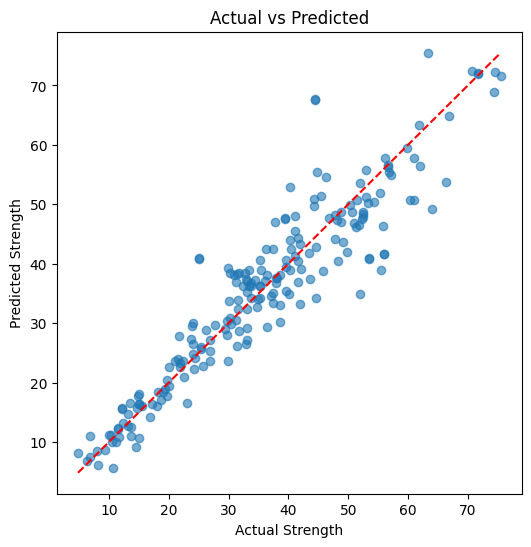

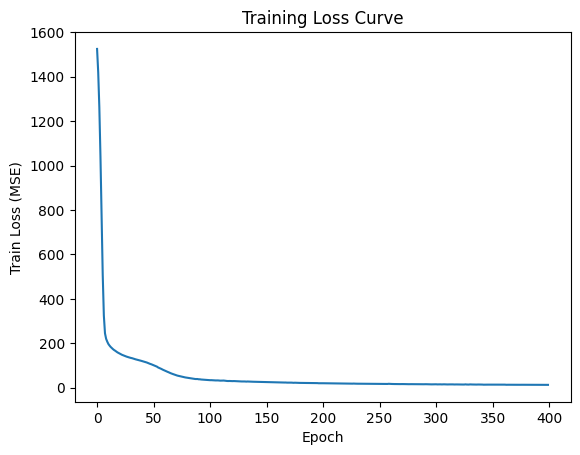

In [19]:
#  Аналіз результатів
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predicted')
plt.show()
print()
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss (MSE)')
plt.title('Training Loss Curve')
plt.show()

# ***Висновки після експерементальної оптимізації***

## ***Порівняння результатів***


MSE = 257
MAE = 13
R_2 ~ 0.0

------------

*Оптимізована модель (ConcreteNetDeep + Adam + weight_decay=1e-4, 400 епох):*


MSE ≈ 32.9 - відмінний результат (<35)

MAE ≈ 3.81 - відмінний результат (<5)

R² ≈ 0.87 - відмінний результат (>0.8)

------------


***Висновки***

1. Навчання моделі:

 - Оптимізована архітектура з більшою кількістю шарів та нейронів змогла краще захопити нелінійні залежності між компонентами бетону та його міцністю.

 - Використання Adam з weight_decay=1e-4 забезпечило стабільну збіжність і уникнення перенавчання.

 - Збільшення кількості епох до 400 дозволило моделі поступово знизити втрати до оптимального рівня.


2. Результати на валідаційній вибірці:

 - Метрики досягли «відмінних» значень за всіма критеріями (MSE, MAE, R²).

 - Це означає, що модель добре узагальнює і може реально прогнозувати міцність бетону на основі його складу.


3. Оцінка:

 - Глибока архітектура дала значний приріст якості, але може бути більш ресурсомісткою.

 - Можна ще експериментувати з Dropout або BatchNorm для додаткової стабільності.

4. Шляхи покращення:

 - Спробувати різні learning rate (наприклад, 0.0005).

 - Додати регуляризацію (Dropout).

 - Перевірити інші оптимізатори (RMSprop).

 - Виконати крос‑валідацію для більш надійної оцінки.















